In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd

# INTRODUCTION

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

## trend and seasonality

In [3]:
def trend(time, slope=0):
    return slope * time

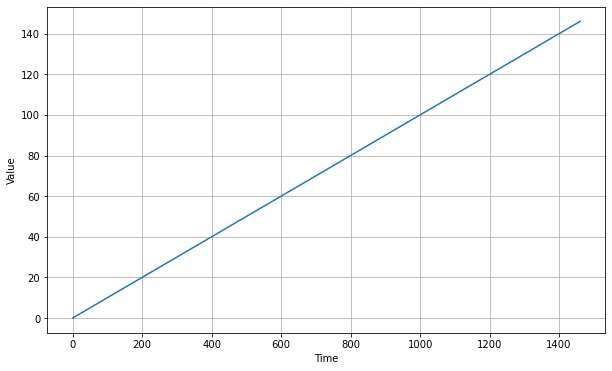

In [4]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

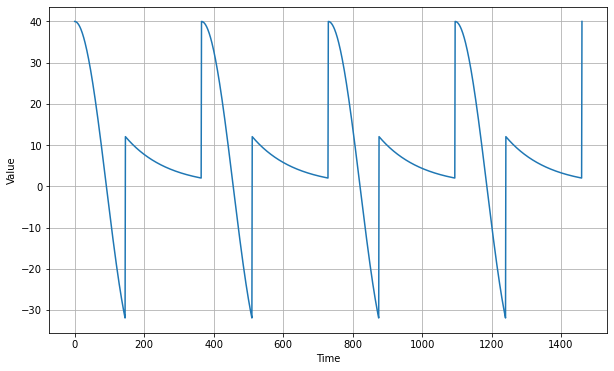

In [6]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

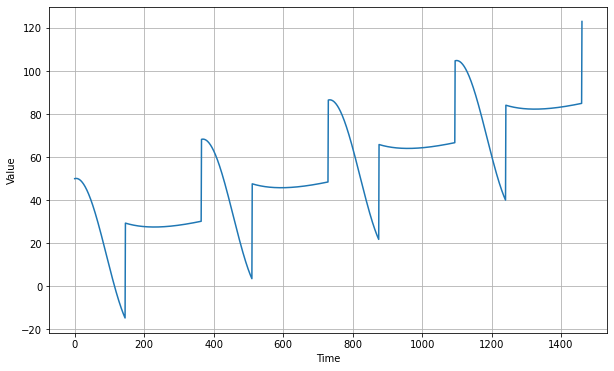

In [7]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## noise 

In [8]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

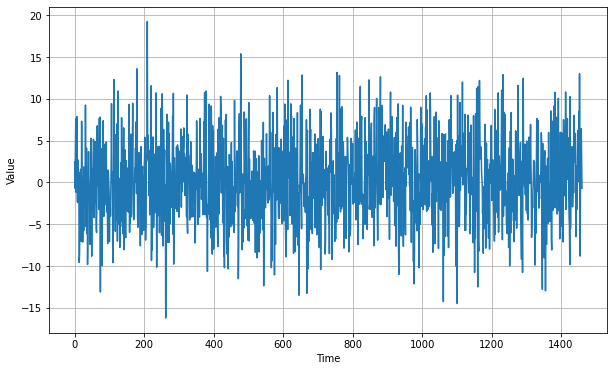

In [9]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

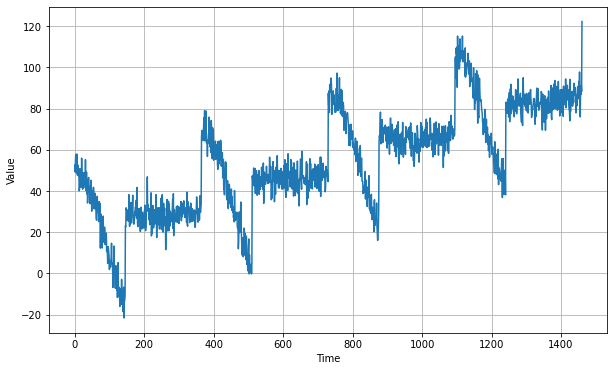

In [10]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [11]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [12]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

In [13]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

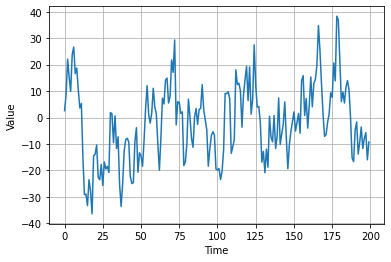

In [14]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

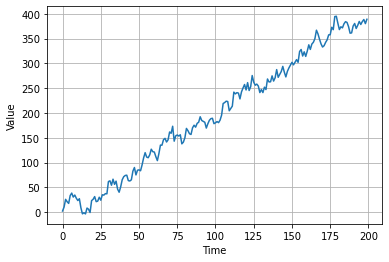

In [15]:
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

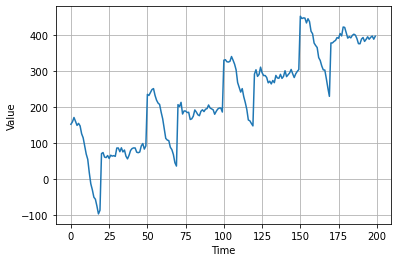

In [16]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

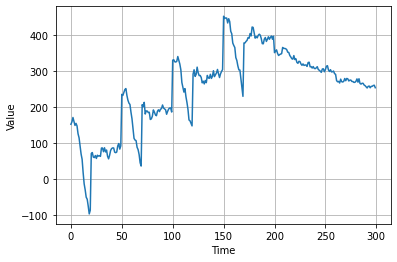

In [17]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
#series += noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()

In [18]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series 

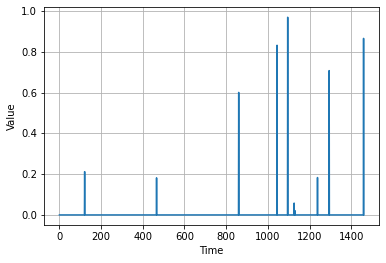

In [19]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [20]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
              ar[step] += φ * ar[step - lag]
    return ar

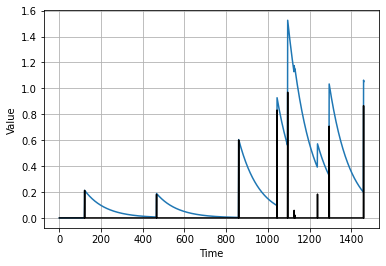

In [21]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

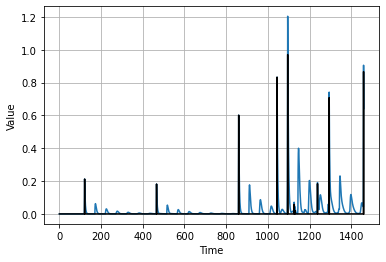

In [22]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

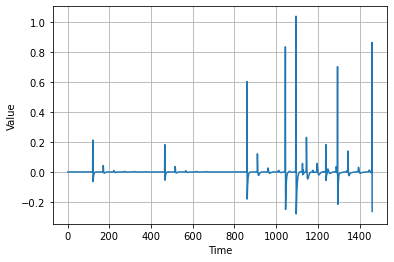

In [23]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

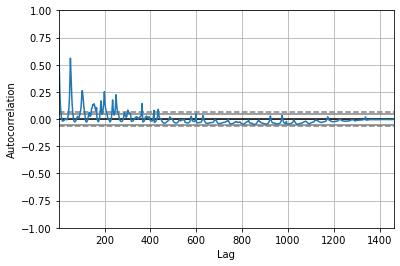

In [24]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [25]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\DELL-POJ\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.428
Method:                       css-mle   S.D. of innovations              0.053
Date:                Sun, 22 Aug 2021   AIC                          -4432.855
Time:                        19:37:53   BIC                          -4395.852
Sample:                             1   HQIC                         -4419.052
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.384      0.701      -0.001       0.002
ar.L1.D.y     -0.1235      0.026     -4.715      0.000      -0.175      -0.072
ar.L2.D.y     -0.1254      0.029     -4.333      0.0

In [26]:
df = pd.read_csv("Sunspots.csv", parse_dates=["Date"], index_col="Date")
series = df["Monthly Mean Total Sunspot Number"].asfreq("1M")
series.head()

Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
Freq: M, Name: Monthly Mean Total Sunspot Number, dtype: float64

<AxesSubplot:xlabel='Date'>

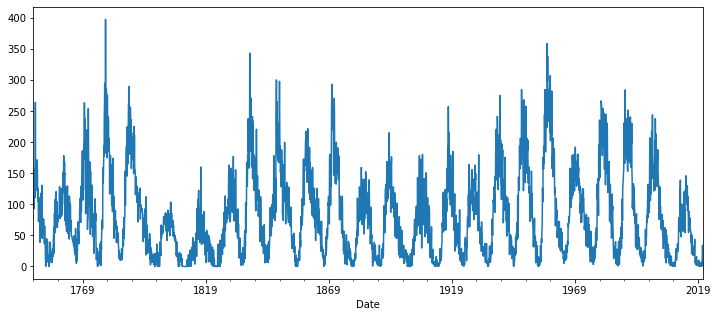

In [27]:
series.plot(figsize=(12, 5))

<AxesSubplot:xlabel='Date'>

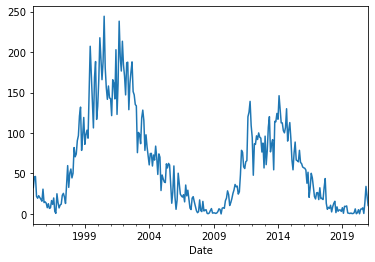

In [28]:
series["1995-01-01":].plot()

(0.0, 100.0, -50.0, 50.0)

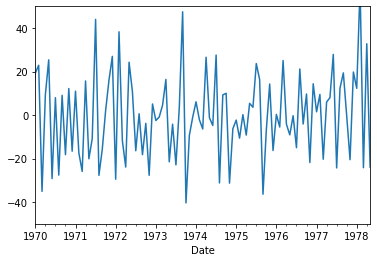

In [29]:
series.diff(1).plot()
plt.axis([0, 100, -50, 50])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

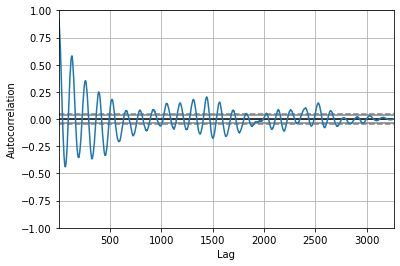

In [30]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

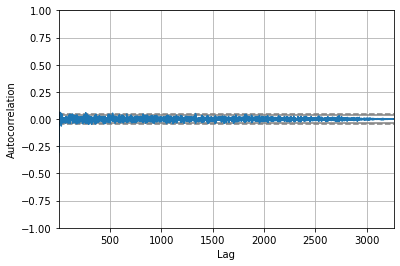

In [31]:
autocorrelation_plot(series.diff(1)[1:])

(0.0, 500.0, -0.1, 0.1)

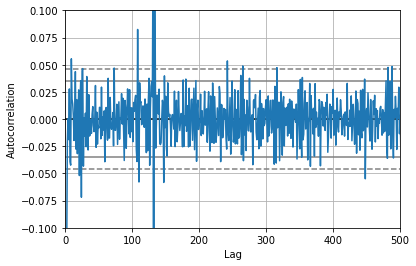

In [32]:
autocorrelation_plot(series.diff(1)[1:].diff(11 * 12)[11*12+1:])
plt.axis([0, 500, -0.1, 0.1])

(0.0, 50.0, -0.1, 0.1)

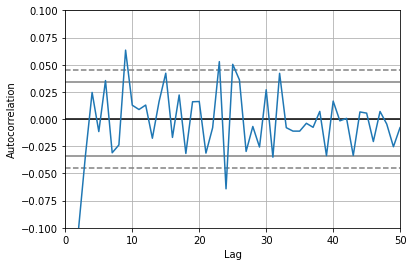

In [33]:
autocorrelation_plot(series.diff(1)[1:])
plt.axis([0, 50, -0.1, 0.1])

# TESTING

In [34]:
print(tf.__version__)

2.4.1


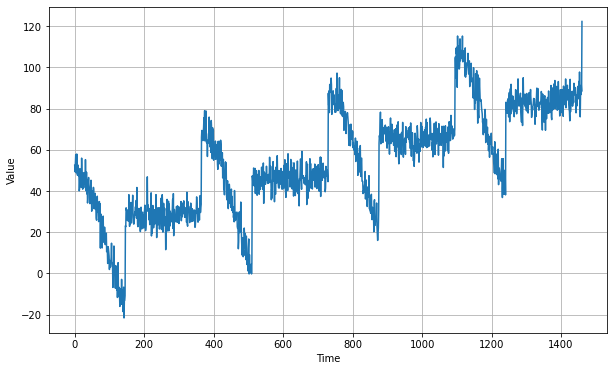

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

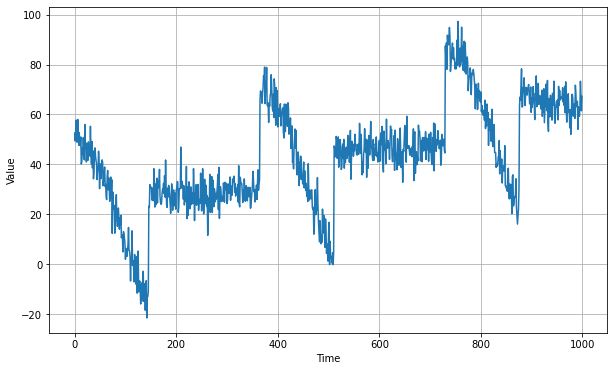

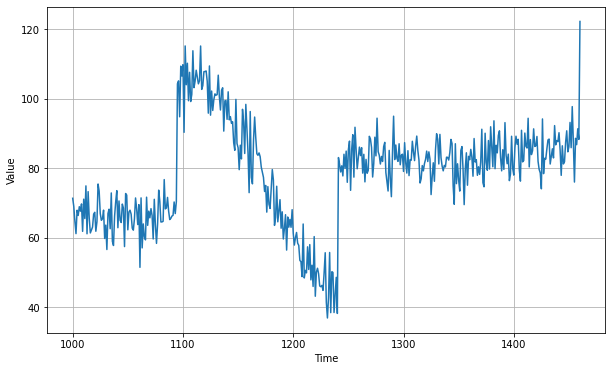

In [36]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

## Naive Forecast 

In [37]:
naive_forecast = series[split_time - 1:-1]

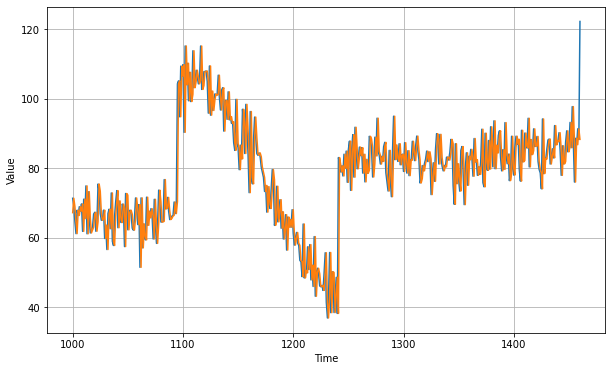

In [38]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

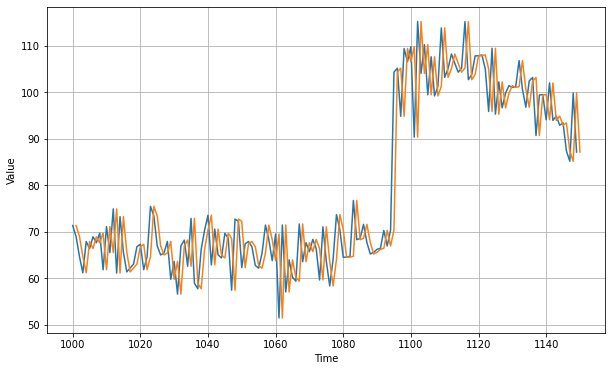

In [39]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

In [40]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827534
5.937908


In [41]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

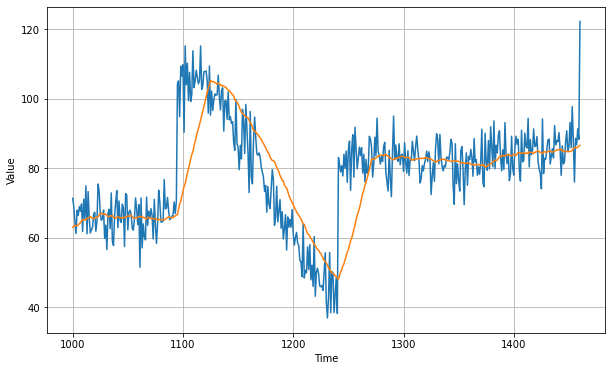

In [42]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [43]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.1424184


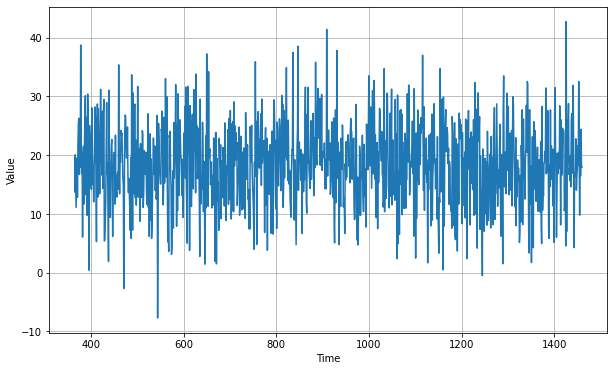

In [44]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

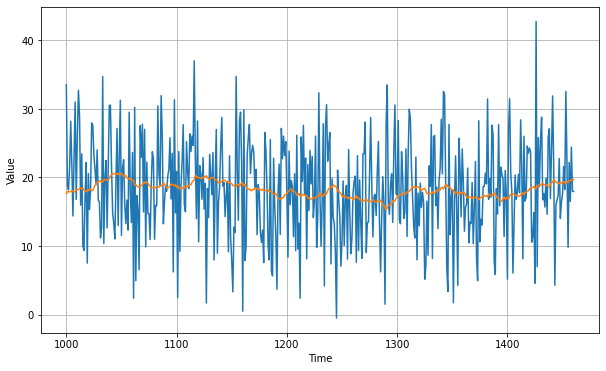

In [45]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

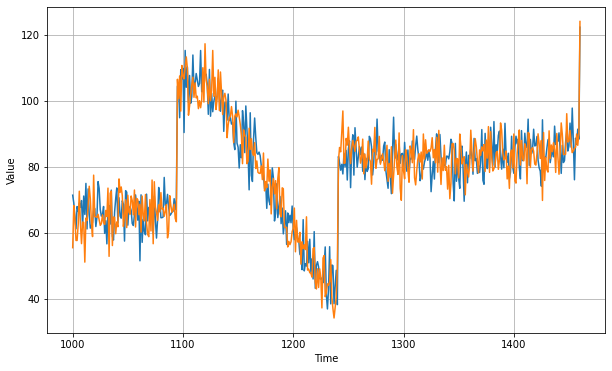

In [46]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [47]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

52.97366
5.839311


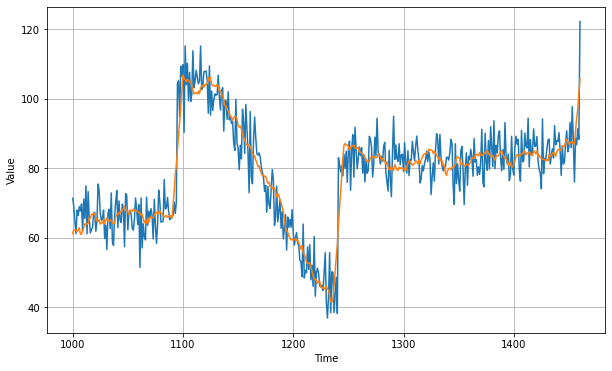

In [48]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [49]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.452263
4.569442


## CNN + LSTM

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [51]:
data = pd.read_csv("daily-min-temperatures.csv")

In [52]:
data.head(4)

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6


In [53]:
data.head(17)

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
5,1981-01-06,15.8
6,1981-01-07,15.8
7,1981-01-08,17.4
8,1981-01-09,21.8
9,1981-01-10,20.0


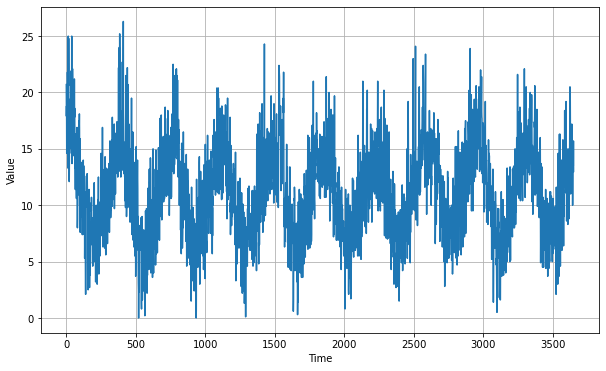

In [54]:
import csv
time_step = []
temps = []

with open('daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1


series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [55]:
time

array([   0,    1,    2, ..., 3647, 3648, 3649])

In [56]:
temps

[20.7,
 17.9,
 18.8,
 14.6,
 15.8,
 15.8,
 15.8,
 17.4,
 21.8,
 20.0,
 16.2,
 13.3,
 16.7,
 21.5,
 25.0,
 20.7,
 20.6,
 24.8,
 17.7,
 15.5,
 18.2,
 12.1,
 14.4,
 16.0,
 16.5,
 18.7,
 19.4,
 17.2,
 15.5,
 15.1,
 15.4,
 15.3,
 18.8,
 21.9,
 19.9,
 16.6,
 16.8,
 14.6,
 17.1,
 25.0,
 15.0,
 13.7,
 13.9,
 18.3,
 22.0,
 22.1,
 21.2,
 18.4,
 16.6,
 16.1,
 15.7,
 16.6,
 16.5,
 14.4,
 14.4,
 18.5,
 16.9,
 17.5,
 21.2,
 17.8,
 18.6,
 17.0,
 16.0,
 13.3,
 14.3,
 11.4,
 16.3,
 16.1,
 11.8,
 12.2,
 14.7,
 11.8,
 11.3,
 10.6,
 11.7,
 14.2,
 11.2,
 16.9,
 16.7,
 8.1,
 8.0,
 8.8,
 13.4,
 10.9,
 13.4,
 11.0,
 15.0,
 15.7,
 14.5,
 15.8,
 16.7,
 16.8,
 17.5,
 17.1,
 18.1,
 16.6,
 10.0,
 14.9,
 15.9,
 13.0,
 7.6,
 11.5,
 13.5,
 13.0,
 13.3,
 12.1,
 12.4,
 13.2,
 13.8,
 10.6,
 9.0,
 10.0,
 9.8,
 11.5,
 8.9,
 7.4,
 9.9,
 9.3,
 9.9,
 7.4,
 8.6,
 11.9,
 14.0,
 8.6,
 10.0,
 13.5,
 12.0,
 10.5,
 10.7,
 8.1,
 10.1,
 10.6,
 5.3,
 6.6,
 8.5,
 11.2,
 9.8,
 5.9,
 3.2,
 2.1,
 3.4,
 5.4,
 9.6,
 11.5,
 12.3,
 12.6,
 11

In [57]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [58]:
x_train

array([20.7, 17.9, 18.8, ...,  9.6, 10.8, 12.1])

In [59]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [60]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [61]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
         tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
         tf.keras.layers.LSTM(64, return_sequences=True),
         tf.keras.layers.LSTM(64, return_sequences=True),
         tf.keras.layers.Dense(30, activation="relu"),
         tf.keras.layers.Dense(10, activation="relu"),
         tf.keras.layers.Dense(1),
         tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 5s 158ms/step - loss: 31.0287 - mae: 31.5267
Epoch 2/100
10/10 [==============================] - 2s 143ms/step - loss: 30.7698 - mae: 31.2675
Epoch 3/100
10/10 [==============================] - 2s 140ms/step - loss: 29.9371 - mae: 30.4346
Epoch 4/100
10/10 [==============================] - 2s 143ms/step - loss: 28.6752 - mae: 29.1725
Epoch 5/100
10/10 [==============================] - 2s 142ms/step - loss: 27.2988 - mae: 27.7959
Epoch 6/100
10/10 [==============================] - 2s 144ms/step - loss: 25.7600 - mae: 26.2569
Epoch 7/100
10/10 [==============================] - 2s 143ms/step - loss: 24.0420 - mae: 24.5383
Epoch 8/100
10/10 [==============================] - 2s 145ms/step - loss: 21.3711 - mae: 21.8673
Epoch 9/100
10/10 [==============================] - 2s 147ms/step - loss: 18.2363 - mae: 18.7317
Epoch 10/100
10/

10/10 [==============================] - 2s 157ms/step - loss: 3.3802 - mae: 3.8522
Epoch 84/100
10/10 [==============================] - 2s 155ms/step - loss: 3.2812 - mae: 3.7545
Epoch 85/100
10/10 [==============================] - 2s 154ms/step - loss: 5.1238 - mae: 5.6081
Epoch 86/100
10/10 [==============================] - 2s 154ms/step - loss: 6.4753 - mae: 6.9669
Epoch 87/100
10/10 [==============================] - 2s 157ms/step - loss: 7.3926 - mae: 7.8856
Epoch 88/100
10/10 [==============================] - 2s 160ms/step - loss: 9.1079 - mae: 9.6041
Epoch 89/100
10/10 [==============================] - 2s 157ms/step - loss: 21.2788 - mae: 21.7674
Epoch 90/100
10/10 [==============================] - 2s 153ms/step - loss: 41.0977 - mae: 41.5976
Epoch 91/100
10/10 [==============================] - 2s 155ms/step - loss: 43.3248 - mae: 43.8247
Epoch 92/100
10/10 [==============================] - 2s 154ms/step - loss: 60.6301 - mae: 61.1297
Epoch 93/100
10/10 [===============

(1e-08, 0.0001, 0.0, 60.0)

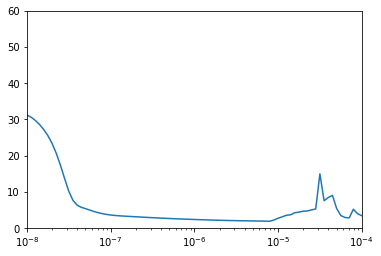

In [62]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [63]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=200, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
          tf.keras.layers.LSTM(60, return_sequences=True),
          tf.keras.layers.LSTM(60, return_sequences=True),
          tf.keras.layers.Dense(30, activation="relu"),
          tf.keras.layers.Dense(10, activation="relu"),
          tf.keras.layers.Dense(1),
          tf.keras.layers.Lambda(lambda x: x * 400) 
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
13/13 [==============================] - 6s 128ms/step - loss: 19.6842 - mae: 20.1788
Epoch 2/150
13/13 [==============================] - 2s 129ms/step - loss: 7.4739 - mae: 7.9645
Epoch 3/150
13/13 [==============================] - 2s 129ms/step - loss: 4.0494 - mae: 4.5268
Epoch 4/150
13/13 [==============================] - 2s 132ms/step - loss: 2.5665 - mae: 3.0313
Epoch 5/150
13/13 [==============================] - 2s 125ms/step - loss: 2.1745 - mae: 2.6327
Epoch 6/150
13/13 [==============================] - 2s 127ms/step - loss: 2.1056 - mae: 2.5634
Epoch 7/150
13/13 [==============================] - 2s 132ms/step - loss: 2.0160 - mae: 2.4719
Epoch 8/150
13/13 [==============================] - 2s 141ms/step - loss: 1.9775 - mae: 2.4330
Epoch 9/150
13/13 [==============================] - 2s 125ms/step - loss: 1.9614 - mae: 2.4171
Epoch 10/150
13/13 [==============================] - 2s 131ms/step - loss: 1.9263 - mae: 2.3807
Epoch 11/150
13/13 [=================

13/13 [==============================] - 2s 135ms/step - loss: 1.5415 - mae: 1.9841
Epoch 86/150
13/13 [==============================] - 2s 138ms/step - loss: 1.5381 - mae: 1.9802
Epoch 87/150
13/13 [==============================] - 2s 133ms/step - loss: 1.5378 - mae: 1.9799
Epoch 88/150
13/13 [==============================] - 2s 135ms/step - loss: 1.5370 - mae: 1.9793
Epoch 89/150
13/13 [==============================] - 2s 145ms/step - loss: 1.5338 - mae: 1.9758
Epoch 90/150
13/13 [==============================] - 2s 141ms/step - loss: 1.5405 - mae: 1.9831
Epoch 91/150
13/13 [==============================] - 2s 140ms/step - loss: 1.5367 - mae: 1.9792
Epoch 92/150
13/13 [==============================] - 2s 136ms/step - loss: 1.5386 - mae: 1.9821
Epoch 93/150
13/13 [==============================] - 2s 137ms/step - loss: 1.5332 - mae: 1.9758
Epoch 94/150
13/13 [==============================] - 2s 144ms/step - loss: 1.5375 - mae: 1.9799
Epoch 95/150
13/13 [=======================

In [64]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

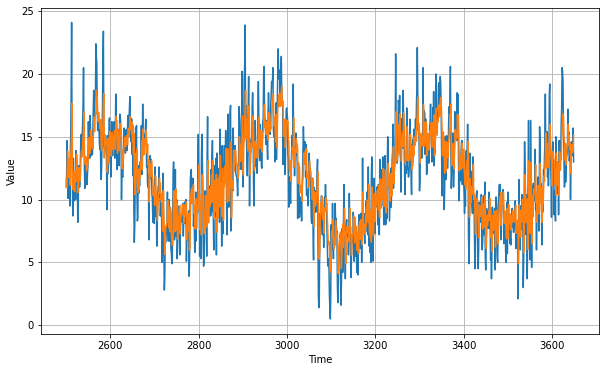

In [65]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [66]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7881743

In [67]:
print(rnn_forecast)

[11.622035 10.947604 12.422933 ... 13.769054 13.963166 15.126067]


## DNN 

In [68]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [69]:
suns_plot = pd.read_csv("Sunspots.csv")
suns_plot.head(3)

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7


In [70]:
suns_plot.shape

(3265, 3)

In [71]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

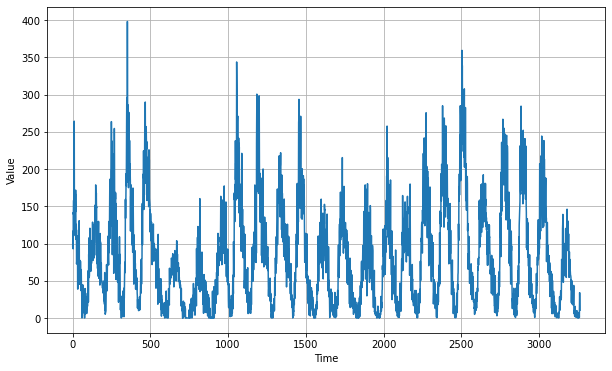

In [72]:
import csv
time_step = []
sunspots = []

with open('Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [73]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [74]:
x_train

array([ 96.7, 104.3, 116.7, ...,  78.5,  97.3, 119.2])

In [75]:
time_train

array([   0,    1,    2, ..., 2997, 2998, 2999])

In [76]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [77]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

In [78]:
dataset

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>

In [79]:
series

array([ 96.7, 104.3, 116.7, ...,  34. ,  21.8,  10.4])

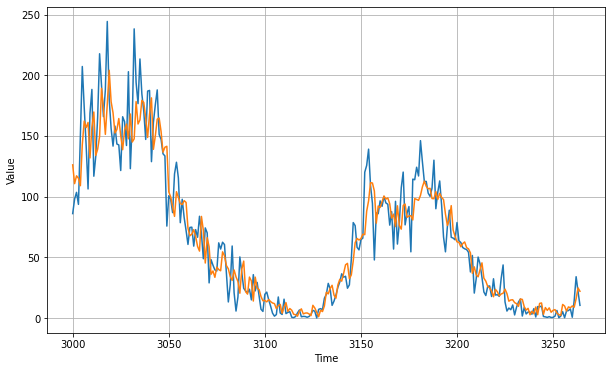

In [81]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [82]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

13.665931

In [83]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [84]:
time

3204

In [87]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

In [90]:
series[time:time + window_size]

array([57. , 56.4, 54.1, 37.9, 51.5, 20.5, 32.4, 50.2, 44.6, 33.4, 21.4,
       18.5, 26.1, 26.4, 17.7, 32.3, 18.9, 19.2, 17.8, 32.6, 43.7, 13.2,
        5.7,  8.2,  6.8, 10.7,  2.5,  8.9, 13.1, 15.6,  1.6,  8.7,  3.3,
        4.9,  4.9,  3.1,  7.7,  0.8,  9.4,  9.1,  9.9,  1.2,  0.9,  0.5,
        1.1,  0.4,  0.5,  1.5,  6.2,  0.2,  1.5,  5.2,  0.2,  5.8,  6.1,
        7.5,  0.6, 14.4, 34. , 21.8])

In [98]:
series

array([ 96.7, 104.3, 116.7, ...,  34. ,  21.8,  10.4])

In [103]:
series[time:time + window_size]

array([57. , 56.4, 54.1, 37.9, 51.5, 20.5, 32.4, 50.2, 44.6, 33.4, 21.4,
       18.5, 26.1, 26.4, 17.7, 32.3, 18.9, 19.2, 17.8, 32.6, 43.7, 13.2,
        5.7,  8.2,  6.8, 10.7,  2.5,  8.9, 13.1, 15.6,  1.6,  8.7,  3.3,
        4.9,  4.9,  3.1,  7.7,  0.8,  9.4,  9.1,  9.9,  1.2,  0.9,  0.5,
        1.1,  0.4,  0.5,  1.5,  6.2,  0.2,  1.5,  5.2,  0.2,  5.8,  6.1,
        7.5,  0.6, 14.4, 34. , 21.8])

In [111]:
time

3204

In [112]:
time + window_size

3264

In [109]:
len(series[time:time + window_size])

60

In [108]:
len(series)

3265

In [106]:
model.predict(series[time:time + window_size][np.newaxis])

array([[21.99649]], dtype=float32)

In [104]:
model.predict(series[time:time + window_size][np.newaxis])

array([[21.99649]], dtype=float32)

In [89]:
len(forecast)

3205

In [107]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________
